# Tweet Sentiment's Impact on Stock Returns的数据分析及预处理
*学号：<u>1120202579</u> 姓名：<u>彭高鹏</u>*

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns

### 1. 数据集简介
该数据集包含 862,231 条带标签的推文和相关的股票回报，全面了解社交媒体对公司层面股票市场表现的影响。对于每条推文，研究人员都提取了推文日期及其相关股票代码等数据，以及最新价格和各种回报（1 天回报、2 天回报、3 天回报、7 天回报）等指标。还记录了 10 天间隔和 30 天间隔的波动率分数。最后，包括来自长短期记忆 （LSTM） 和 TextBlob 模型的情绪分数，以量化这些消息传递的整体基调。<br/>
**TWEET**:推文的文本 (String)<br/>
**STOCK**:推文中提到的公司股票 (String)<br/>
**DATE**:推文的发布日期 (Date)<br/>
**LAST_PRICE**:公司发布推文时的最后价格 (Float)<br/>
**1_DAY_RETURN**:股票在推特上发布后的第二天退回或损失的金额 (Float)<br/>
**2_DAY_RETURN**:在推文发布后的两天内退回或损失的股票金额 (Float)<br/>
**3_DAY_RETURN**:股票在被推文发布后的三天内退回或损失的金额 (Float)<br/>
**7_DAY_RETURN**:在推文发布后的 7 天内退回或损失的股票金额 (Float)<br/>
**PX_VOLUME**:发推文时的交易量 (Integer)<br/>
**VOLATILITY_10D**:跨 10 天窗口的波动率衡量 (Float)<br/>
**VOLATILITY_30D**:波动率衡量 30 天窗口 (Float)<br/>
**LSTM_POLARITY**来自 LSTM 的标记情绪 (Float)<br/>
**TEXTBLOB_POLARITY**:来自 TextBlob 的标记情绪 (Float)<br/>

下面对数据集的csv文件进行读取，并展示前几个数据对象

In [2]:
df = pd.read_csv('full_dataset-release.csv')
df.info()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25684\3661070278.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('full_dataset-release.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395450 entries, 0 to 1395449
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1102013 non-null  object 
 1   TWEET              1395398 non-null  object 
 2   STOCK              862231 non-null   object 
 3   DATE               862231 non-null   object 
 4   LAST_PRICE         862231 non-null   float64
 5   1_DAY_RETURN       862231 non-null   float64
 6   2_DAY_RETURN       862231 non-null   float64
 7   3_DAY_RETURN       862231 non-null   float64
 8   7_DAY_RETURN       862231 non-null   float64
 9   PX_VOLUME          862231 non-null   float64
 10  VOLATILITY_10D     862130 non-null   float64
 11  VOLATILITY_30D     862184 non-null   float64
 12  LSTM_POLARITY      661102 non-null   float64
 13  TEXTBLOB_POLARITY  367665 non-null   float64
dtypes: float64(10), object(4)
memory usage: 149.1+ MB


In [3]:
df.head(5)

,Unnamed: 0,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,0,RT @robertoglezcano: @amazon #Patents Show Fl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,1.000,0.0,NaN
2,1,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1.0,0.0
3,2,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,1.0,0.0
4,3,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1.0,0.0


定义分析数据的方案，包括展示数据信息、绘制数据的直方图和盒图

In [4]:
#定义标称型数据的分析方案
def analyze_freq_nominal(name,data,draw=True):
    freq = data.value_counts()
    print("Frequency information of the {}:\n".format(freq))
    print("Missing Value Count:",data.isnull().sum())

    if draw:
    # 绘制处理数据的频数直方图
        plt.figure(figsize=(12,5))
        plt.bar(freq.index,freq.values)
        plt.title(name + ' Frequency Histogram')
        plt.xlabel(name)
        plt.ylabel(' Frequency')
        plt.grid(axis='y')
        plt.tick_params(axis='x', labelsize=8)
        plt.xticks(rotation=-50)
        plt.tight_layout()
        plt.show()

#定义数值型数据的分析方案
def analyze_freq_and_box_numeric(name,data,draw=True,bin_set=None):
    print("The Information of {}:\n".format(name))
    print(data.describe())
    print("Missing Value Count:",data.isnull().sum())

    if draw:
        # 绘制数据的频数直方图
        plt.figure(figsize=(24,5))
        plt.subplot(1, 2, 1)
        if bin_set:
            sns.histplot(data,bins=bin_set,kde=True)
        else:
            sns.histplot(data, kde=True)
        plt.title(name + ' Frequency Histogram')
        plt.xlabel(name)
        plt.ylabel(' Frequency')
        plt.grid(axis='y')

        #绘制数据的盒图
        plt.subplot(1, 2, 2)
        sns.boxplot(data)
        plt.title( name + ' Boxplot')
        plt.ylabel(name)
        plt.grid(axis='y')

        plt.tight_layout()
        plt.show()


### 2. 数据摘要和可视化
* **数据摘要**</br>
      标称属性，给出每个可能取值的频数</br>
      数值属性，给出5数概括及缺失值的个数

* **数据可视化**</br>
      使用直方图、盒图等检查数据分布及离群点

#### 2.1 分析标称型数据
数据集中的标称型数据有：推文的文本TWEET,推文中提到的公司股票STOCK<br/>
其中对于数据类型较多的数据，我们不进行画图，只进行频数分析

In [5]:
nominal_df = df.select_dtypes(include=['object'])
print(nominal_df.columns)

Index(['Unnamed: 0', 'TWEET', 'STOCK', 'DATE'], dtype='object')


In [6]:
analyze_freq_nominal('TWEET',nominal_df['TWEET'],draw=False)
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n")
analyze_freq_nominal('STOCK',nominal_df['STOCK'],draw=False)
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n")

Frequency information of the TWEET
Facebook                                                                                                                                          44257
Ford                                                                                                                                              38389
Next week: Saturday 1st Sep                                                                                                                       29111
Nike                                                                                                                                              28874
Apple                                                                                                                                             23033
                                                                                                                                                  ...  
RT @denverpolitics: Exxon settles pollution case with

#### 2.2 分析数值型数据
数据集中的数值型数据有：LAST_PRICE，1_DAY_RETURN，2_DAY_RETURN，3_DAY_RETURN，PX_VOLUME，VOLATILITY_10D，VOLATILITY_30D，LSTM_POLARITY，TEXTBLOB_POLARITY
下面我们对以上几个数值型数据逐一进行分析

In [7]:
numeric_df = df.select_dtypes(include=['int64','float64'])
print(numeric_df.columns)

Index(['LAST_PRICE', '1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN',
       '7_DAY_RETURN', 'PX_VOLUME', 'VOLATILITY_10D', 'VOLATILITY_30D',
       'LSTM_POLARITY', 'TEXTBLOB_POLARITY'],
      dtype='object')


The Information of LAST_PRICE:

count    862231.000000
mean        716.123477
std        4731.498118
min          -0.173554
25%           0.000000
50%           0.014220
75%         115.600000
max      165500.000000
Name: LAST_PRICE, dtype: float64
Missing Value Count: 533219


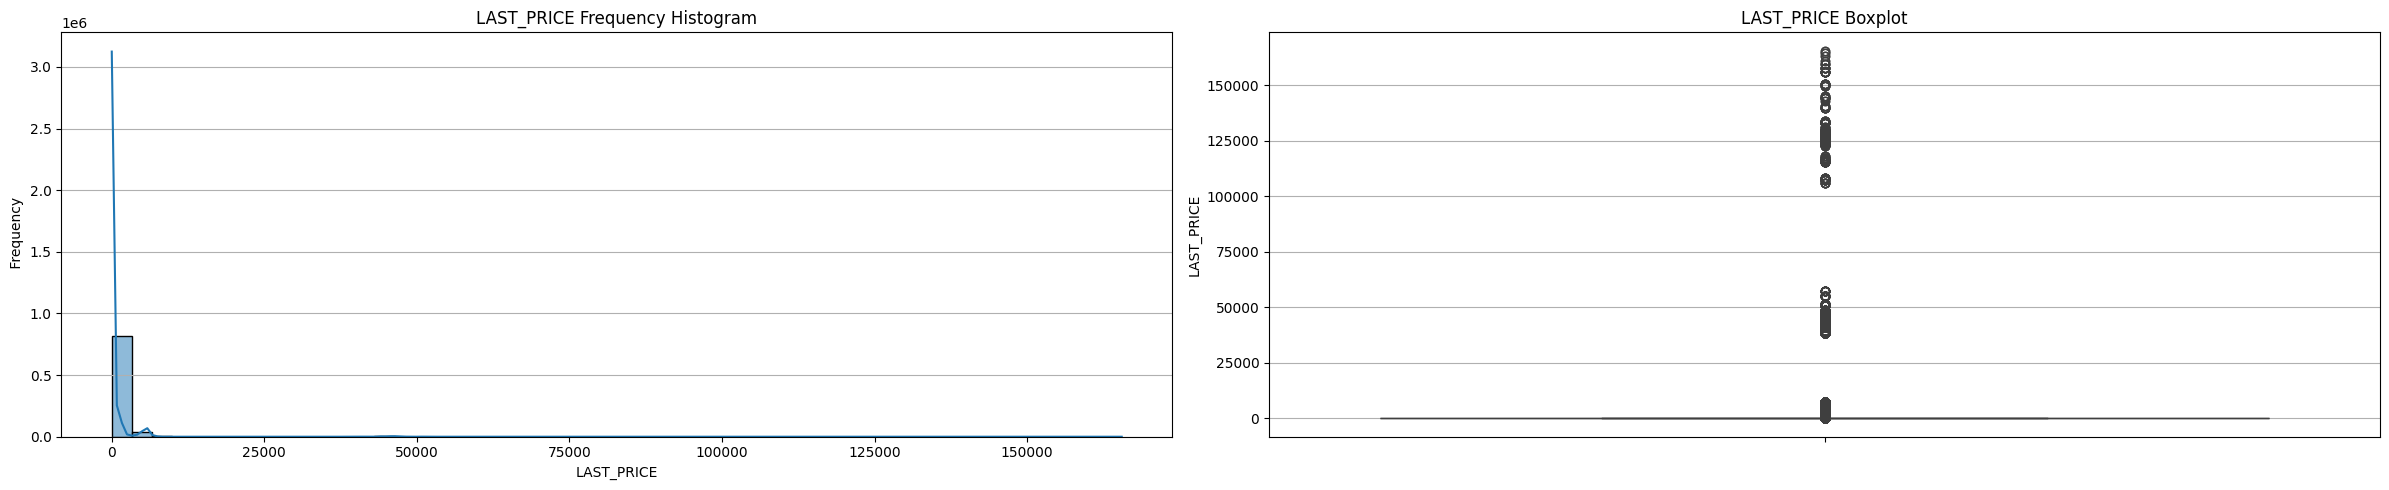

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The Information of 1_DAY_RETURN:

count    862231.000000
mean          0.001473
std           0.023068
min          -0.177851
25%          -0.007511
50%           0.000000
75%           0.008192
max           0.243639
Name: 1_DAY_RETURN, dtype: float64
Missing Value Count: 533219


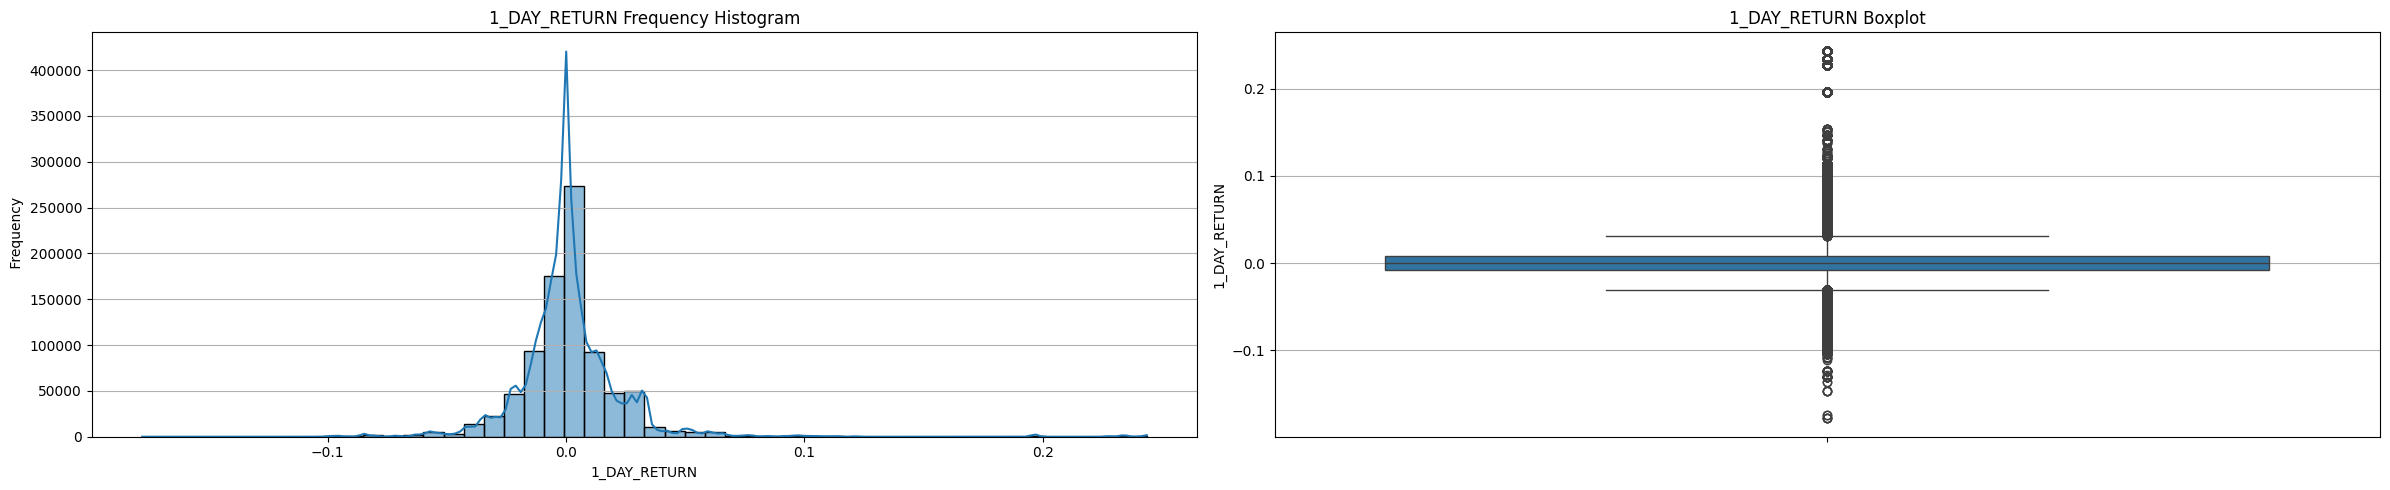

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The Information of 2_DAY_RETURN:

count    862231.000000
mean          0.002579
std           0.032594
min          -0.204959
25%          -0.011456
50%           0.000000
75%           0.013911
max           0.267113
Name: 2_DAY_RETURN, dtype: float64
Missing Value Count: 533219


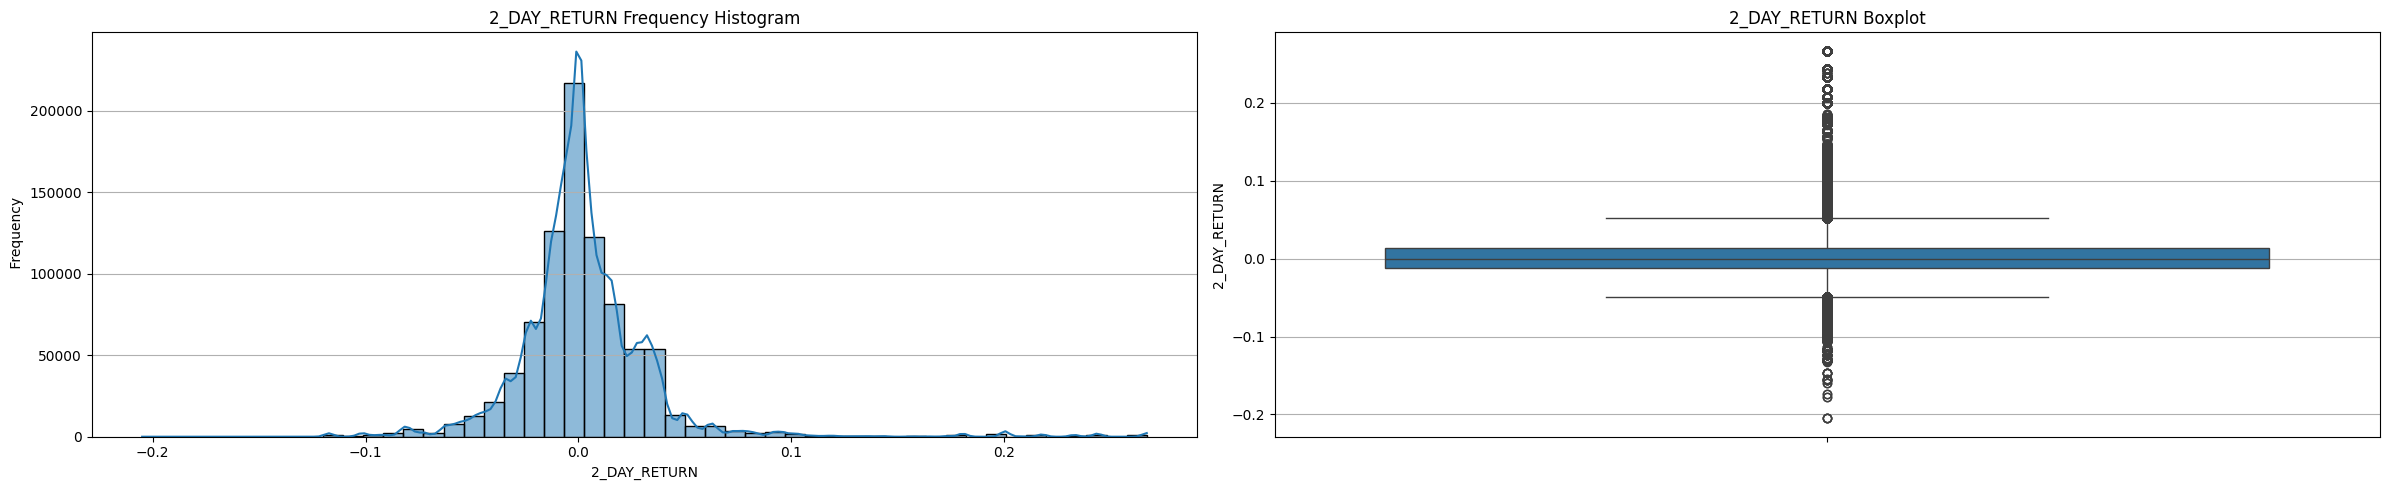

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The Information of 3_DAY_RETURN:

count    8.622310e+05
mean     3.262616e+06
std      1.053913e+07
min     -2.049587e-01
25%     -8.465608e-03
50%      1.019542e-02
75%      6.545426e-02
max      3.081068e+08
Name: 3_DAY_RETURN, dtype: float64
Missing Value Count: 533219


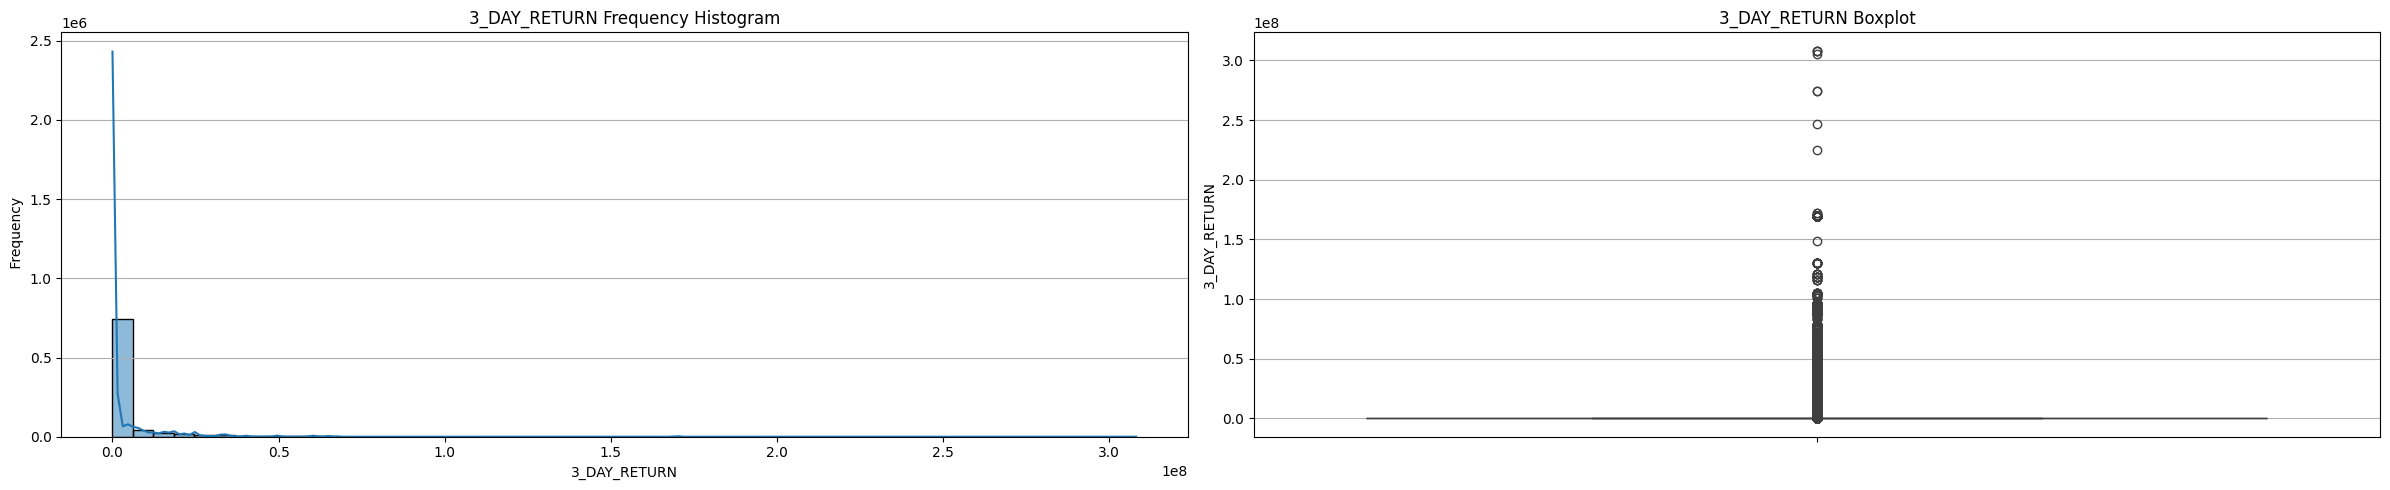

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The Information of 7_DAY_RETURN:

count    8.622310e+05
mean     6.201036e+06
std      1.388221e+07
min     -2.049587e-01
25%      5.474453e-03
50%      1.575000e+01
75%      4.766038e+06
max      1.562074e+08
Name: 7_DAY_RETURN, dtype: float64
Missing Value Count: 533219


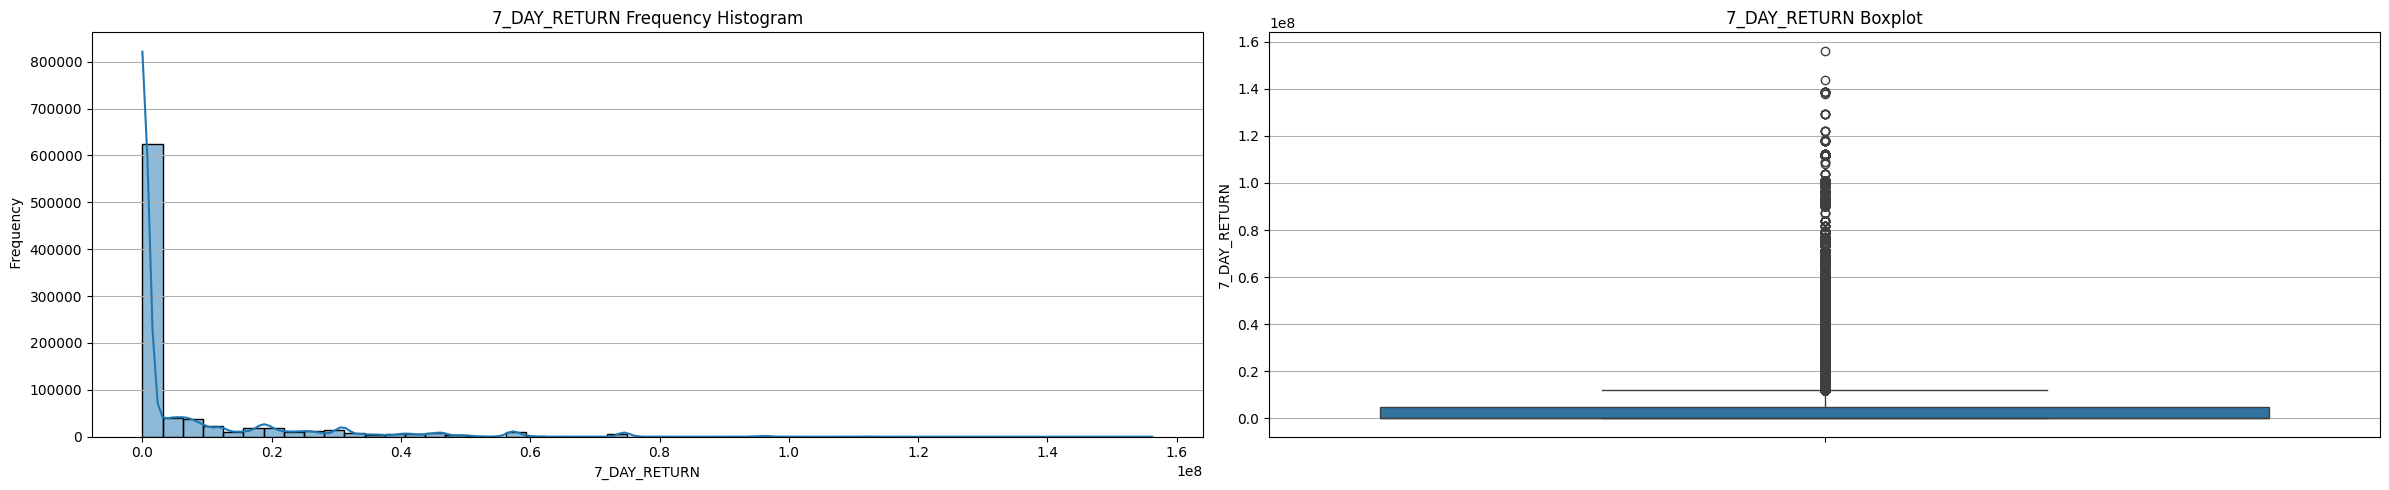

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The Information of PX_VOLUME:

count    8.622310e+05
mean     7.522187e+06
std      1.591847e+07
min      1.000000e+00
25%      2.051700e+01
50%      3.979400e+01
75%      6.531761e+06
max      3.148332e+08
Name: PX_VOLUME, dtype: float64
Missing Value Count: 533219


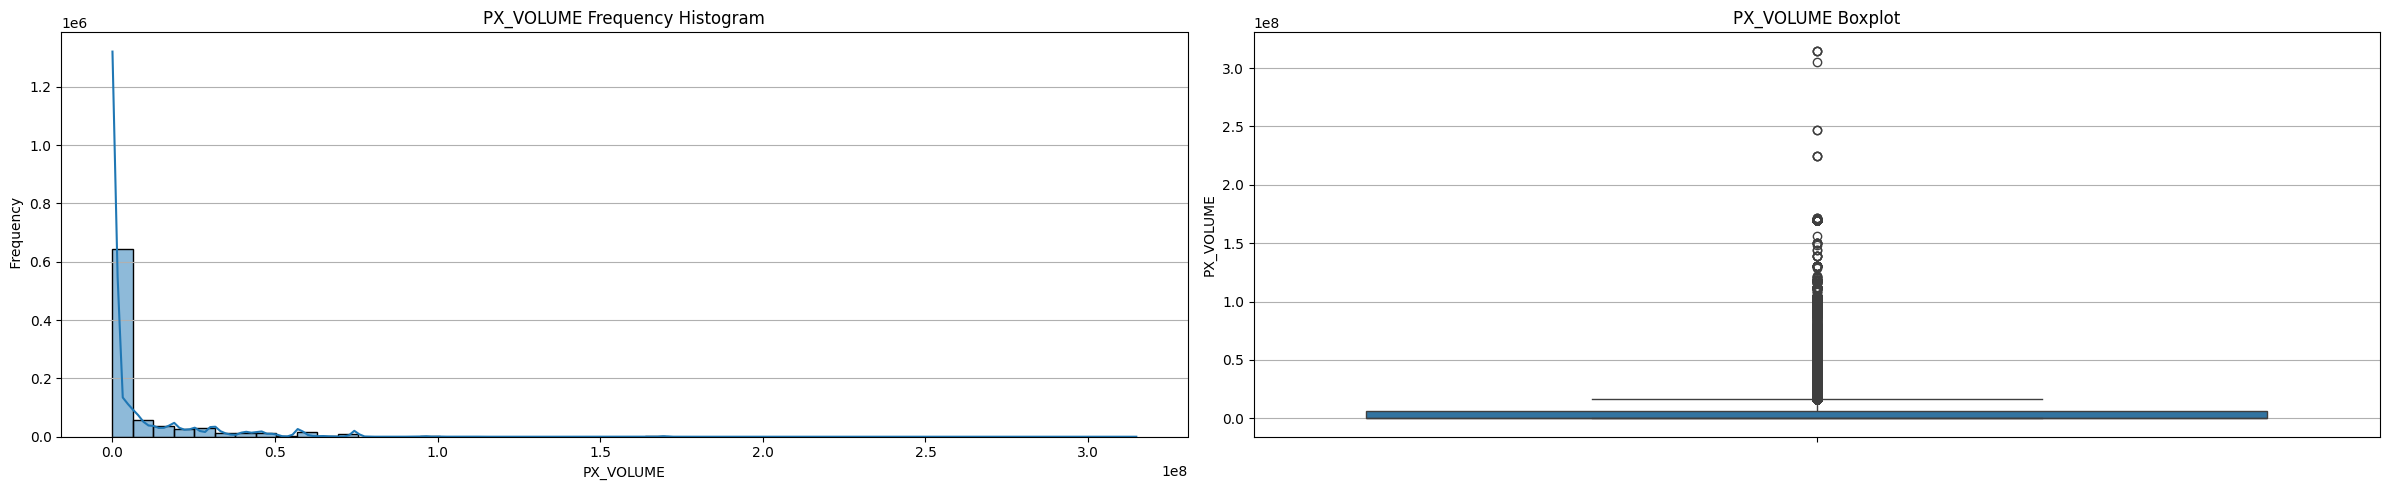

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The Information of VOLATILITY_10D:

count    862130.000000
mean         18.293836
std          16.277630
min          -1.000000
25%           8.792000
50%          17.897000
75%          23.916000
max         124.137000
Name: VOLATILITY_10D, dtype: float64
Missing Value Count: 533320


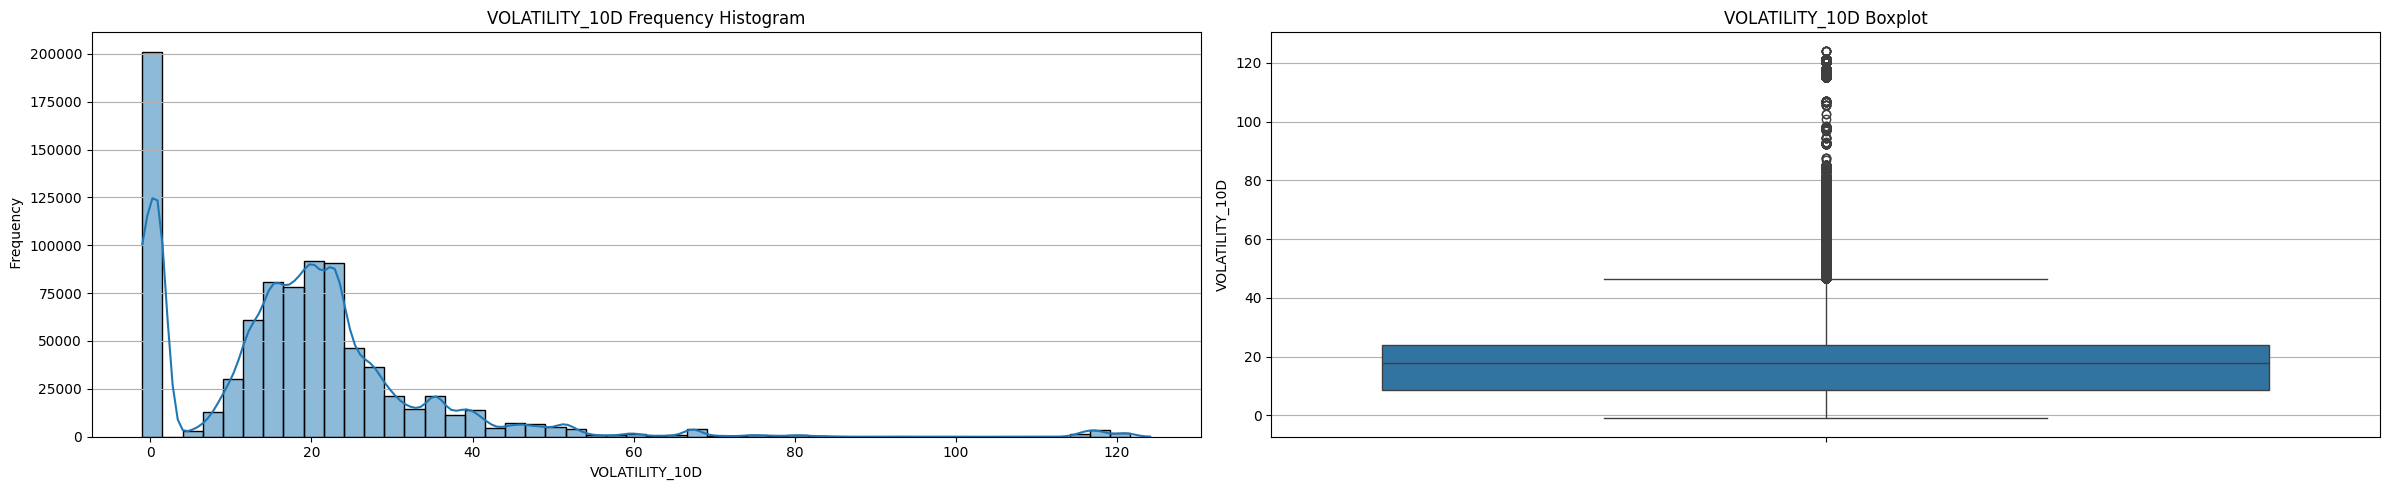

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The Information of VOLATILITY_30D:

count    862184.000000
mean         10.738204
std          14.693986
min          -1.000000
25%           0.000000
50%           1.000000
75%          20.810000
max          87.685000
Name: VOLATILITY_30D, dtype: float64
Missing Value Count: 533266


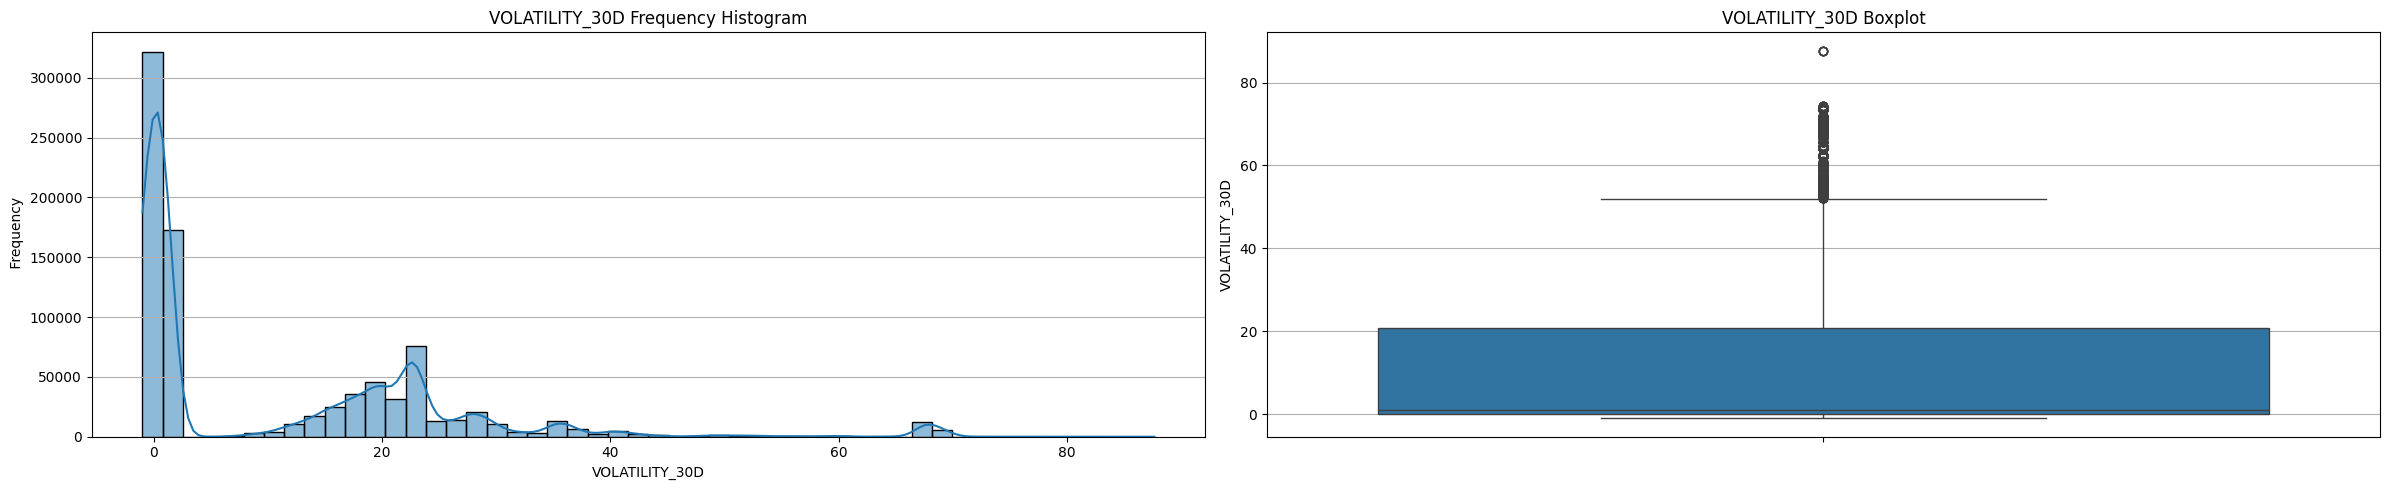

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The Information of LSTM_POLARITY:

count    661102.000000
mean          0.099378
std           0.760510
min          -1.000000
25%          -0.600000
50%           0.000000
75%           1.000000
max           1.000000
Name: LSTM_POLARITY, dtype: float64
Missing Value Count: 734348


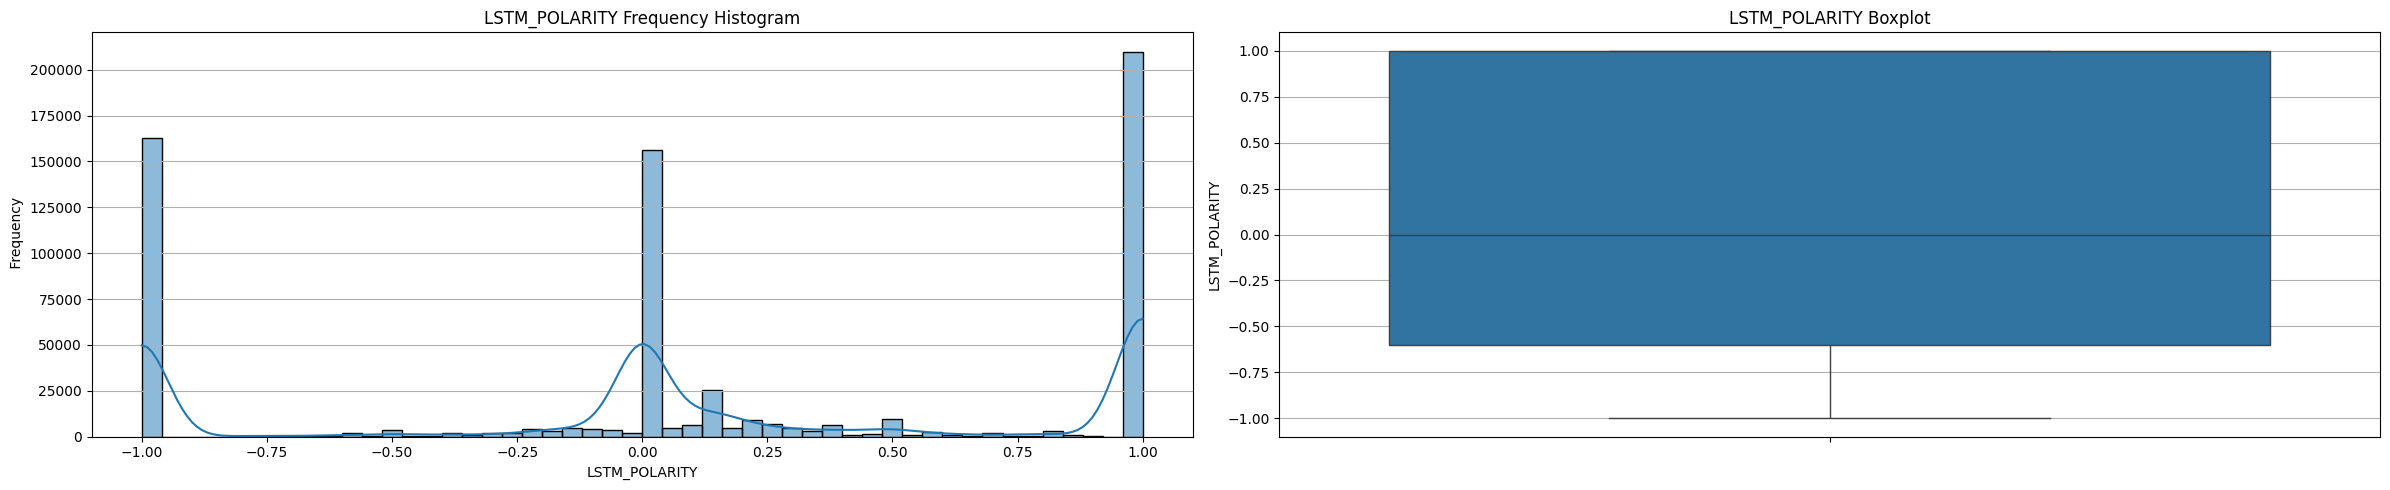

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

The Information of TEXTBLOB_POLARITY:

count    367665.000000
mean          0.076176
std           0.261048
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.150000
max           1.000000
Name: TEXTBLOB_POLARITY, dtype: float64
Missing Value Count: 1027785


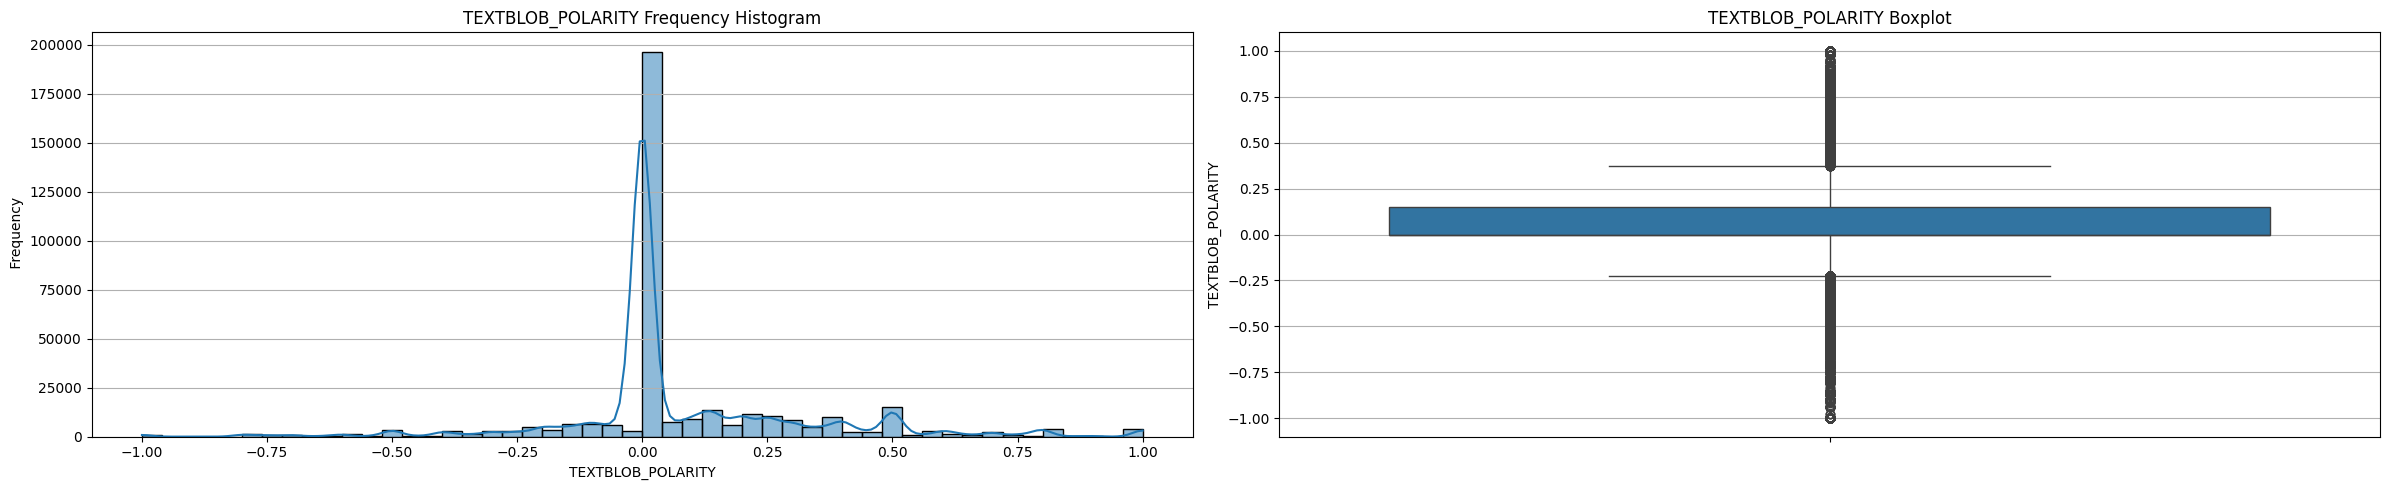

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>



In [8]:
for i in numeric_df.columns:
    analyze_freq_and_box_numeric(i,numeric_df[i],draw=True,bin_set=50)
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n")

### 3. 数据缺失的处理
观察数据集中缺失数据，分析其缺失的原因。分别使用下列四种策略对缺失值进行处理: </br>

* 将缺失部分剔除
* 用最高频率值来填补缺失值
* 通过属性的相关关系来填补缺失值
* 通过数据对象之间的相似性来填补缺失值

#### 3.1 分析数据缺失的原因
该数据集几乎所有的属性都有或多或少数量的缺失值，从前面对标称型数据和数值型数据的分析来看，二者也各自都有部分缺失值。</br>
数据缺失的原因可能有以下几点：</br>
* 股价信息的缺失，股票本身的信息不全
* 爬取股价信息的程序算法不完备

#### 3.2 剔除有缺失值的数据对象

In [9]:
data = df.dropna()

展示填补前的数据信息

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395450 entries, 0 to 1395449
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1102013 non-null  object 
 1   TWEET              1395398 non-null  object 
 2   STOCK              862231 non-null   object 
 3   DATE               862231 non-null   object 
 4   LAST_PRICE         862231 non-null   float64
 5   1_DAY_RETURN       862231 non-null   float64
 6   2_DAY_RETURN       862231 non-null   float64
 7   3_DAY_RETURN       862231 non-null   float64
 8   7_DAY_RETURN       862231 non-null   float64
 9   PX_VOLUME          862231 non-null   float64
 10  VOLATILITY_10D     862130 non-null   float64
 11  VOLATILITY_30D     862184 non-null   float64
 12  LSTM_POLARITY      661102 non-null   float64
 13  TEXTBLOB_POLARITY  367665 non-null   float64
dtypes: float64(10), object(4)
memory usage: 149.1+ MB


In [11]:
df.head(10)

,Unnamed: 0,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,0,RT @robertoglezcano: @amazon #Patents Show Fl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,1.000,0.0,NaN
2,1,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1.0,0.0
3,2,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,1.0,0.0
4,3,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1.0,0.0
5,4,RT @loadsofvans: Retweet this post &amp; follo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,-1.000,0.8,NaN
7,5,RT @Disney: See The Newest Trailer for #Beauty...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Disney,31/01/2017,110.65,0.002621,-0.012201,-0.012201,-0.024853,8.485838e+06,12.229,12.982,1.000,0.0,NaN
9,6,RT @tarastrong: Just got @facebook back! I REA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


填补后的数据集信息如下：

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367620 entries, 2 to 1395443
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         367620 non-null  object 
 1   TWEET              367620 non-null  object 
 2   STOCK              367620 non-null  object 
 3   DATE               367620 non-null  object 
 4   LAST_PRICE         367620 non-null  float64
 5   1_DAY_RETURN       367620 non-null  float64
 6   2_DAY_RETURN       367620 non-null  float64
 7   3_DAY_RETURN       367620 non-null  float64
 8   7_DAY_RETURN       367620 non-null  float64
 9   PX_VOLUME          367620 non-null  float64
 10  VOLATILITY_10D     367620 non-null  float64
 11  VOLATILITY_30D     367620 non-null  float64
 12  LSTM_POLARITY      367620 non-null  float64
 13  TEXTBLOB_POLARITY  367620 non-null  float64
dtypes: float64(10), object(4)
memory usage: 42.1+ MB


In [13]:
data.head(10)

,Unnamed: 0,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
2,1,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,31/01/2017,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.00
3,2,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,31/01/2017,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,1.0,0.00
4,3,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,31/01/2017,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.00
11,7,"RT @nikitakhara: Thank you, @Starbucks CEO for...",Starbucks,31/01/2017,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298,1.0,0.20
20,12,@gawker Jamaicans make money with @Payoneer @P...,PayPal,31/01/2017,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.00
23,14,RT @cultcommoncore: Dumping @Starbucks\r\r\r\r...,Starbucks,31/01/2017,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298,-1.0,0.00
26,16,@amazon has your back when it comes to food sh...,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3137196.0,13.447,16.992,-1.0,0.00
35,21,"RT @nia4_trump: So instead of hiring 10,000 un...",Starbucks,31/01/2017,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298,-1.0,0.00
48,28,Hmmm interesting... \r\r\r\r\r\r\nonly @IBM ha...,Disney,31/01/2017,110.65,0.002621,-0.012201,-0.012201,-0.024853,8485838.0,12.229,12.982,-1.0,0.25
53,31,RT @IndiaHistorypic: 1994::Young @sundarpichai...,Google,31/01/2017,820.19,0.004438,0.030286,0.030286,0.035772,2020180.0,21.549,14.953,-1.0,0.00


##### 比较处理前后数据集差异
下面以1_DAY_RETURN 这一属性为例，对比数据集在剔除含缺失值数据对象后的差异

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Before Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
The Information of 1_DAY_RETURN :

count    862231.000000
mean          0.001473
std           0.023068
min          -0.177851
25%          -0.007511
50%           0.000000
75%           0.008192
max           0.243639
Name: 1_DAY_RETURN, dtype: float64
Missing Value Count: 533219


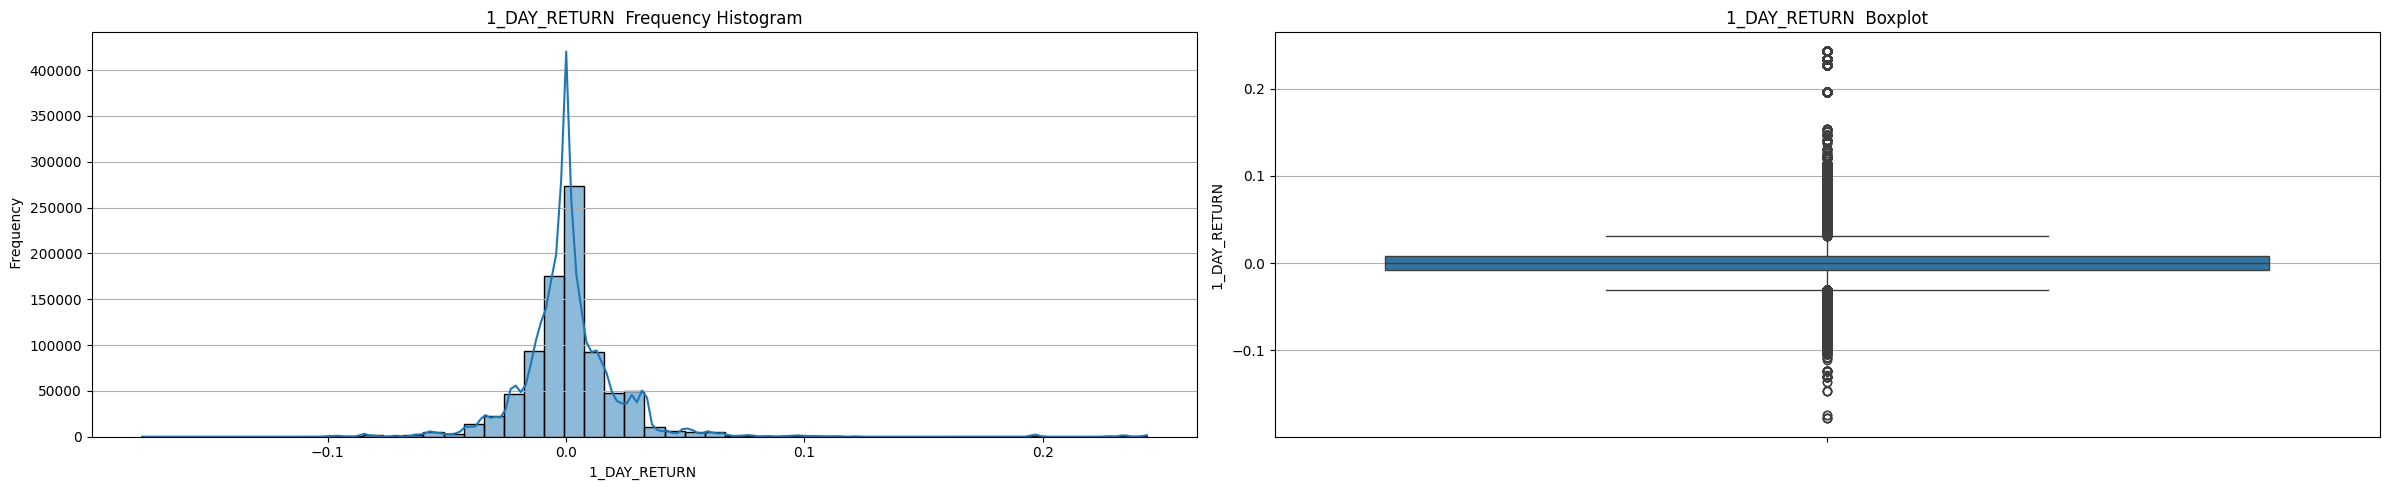

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>After Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
The Information of 1_DAY_RETURN :

count    367620.000000
mean          0.000832
std           0.018203
min          -0.146650
25%          -0.005570
50%           0.000000
75%           0.004407
max           0.233973
Name: 1_DAY_RETURN, dtype: float64
Missing Value Count: 0


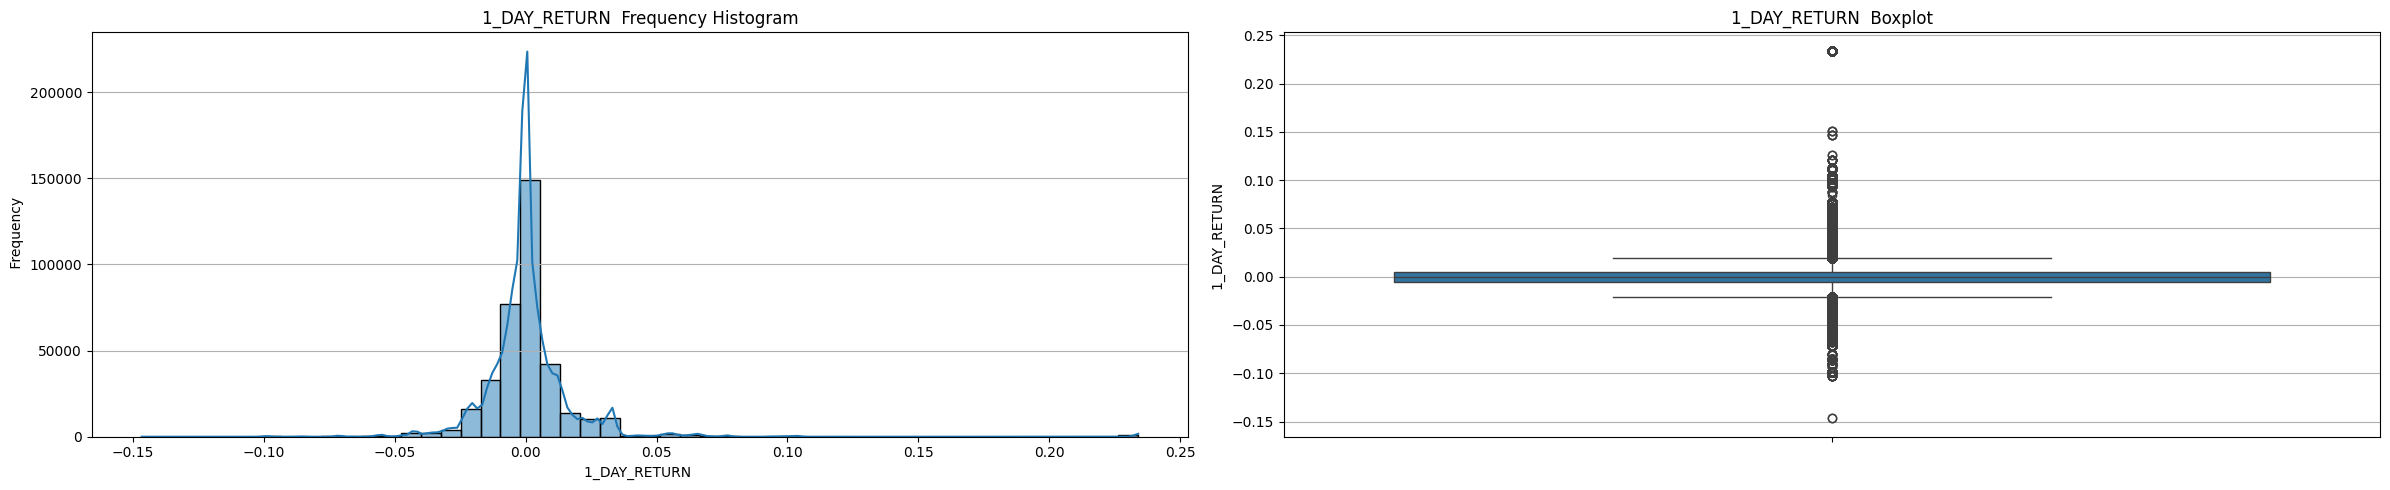

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [14]:
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Before Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
analyze_freq_and_box_numeric("1_DAY_RETURN ",df["1_DAY_RETURN"],draw=True,bin_set=50)
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>After Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
analyze_freq_and_box_numeric("1_DAY_RETURN ",data["1_DAY_RETURN"],draw=True,bin_set=50)
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

#### 3.3 用最高频率值来填补缺失值 

In [15]:
data = df.copy(deep=True)

展示填补前的数据信息

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395450 entries, 0 to 1395449
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1102013 non-null  object 
 1   TWEET              1395398 non-null  object 
 2   STOCK              862231 non-null   object 
 3   DATE               862231 non-null   object 
 4   LAST_PRICE         862231 non-null   float64
 5   1_DAY_RETURN       862231 non-null   float64
 6   2_DAY_RETURN       862231 non-null   float64
 7   3_DAY_RETURN       862231 non-null   float64
 8   7_DAY_RETURN       862231 non-null   float64
 9   PX_VOLUME          862231 non-null   float64
 10  VOLATILITY_10D     862130 non-null   float64
 11  VOLATILITY_30D     862184 non-null   float64
 12  LSTM_POLARITY      661102 non-null   float64
 13  TEXTBLOB_POLARITY  367665 non-null   float64
dtypes: float64(10), object(4)
memory usage: 149.1+ MB


In [17]:
data.head(10)

,Unnamed: 0,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,0,RT @robertoglezcano: @amazon #Patents Show Fl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,1.000,0.0,NaN
2,1,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1.0,0.0
3,2,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,1.0,0.0
4,3,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1.0,0.0
5,4,RT @loadsofvans: Retweet this post &amp; follo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,-1.000,0.8,NaN
7,5,RT @Disney: See The Newest Trailer for #Beauty...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Disney,31/01/2017,110.65,0.002621,-0.012201,-0.012201,-0.024853,8.485838e+06,12.229,12.982,1.000,0.0,NaN
9,6,RT @tarastrong: Just got @facebook back! I REA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
for i in data.columns:
    if not data[i].isnull().any():
        continue
    data[i] = data[i].fillna(data[i].dropna().mode()[0])

填补后的数据集信息如下：

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395450 entries, 0 to 1395449
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1395450 non-null  object 
 1   TWEET              1395450 non-null  object 
 2   STOCK              1395450 non-null  object 
 3   DATE               1395450 non-null  object 
 4   LAST_PRICE         1395450 non-null  float64
 5   1_DAY_RETURN       1395450 non-null  float64
 6   2_DAY_RETURN       1395450 non-null  float64
 7   3_DAY_RETURN       1395450 non-null  float64
 8   7_DAY_RETURN       1395450 non-null  float64
 9   PX_VOLUME          1395450 non-null  float64
 10  VOLATILITY_10D     1395450 non-null  float64
 11  VOLATILITY_30D     1395450 non-null  float64
 12  LSTM_POLARITY      1395450 non-null  float64
 13  TEXTBLOB_POLARITY  1395450 non-null  float64
dtypes: float64(10), object(4)
memory usage: 149.1+ MB


In [20]:
data.head(10)

,Unnamed: 0,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,0,RT @robertoglezcano: @amazon #Patents Show Fl...,Ford,0.0,0.000000,0.000000,0.000000,0.039003,6.486486e-02,3.098723e+07,1.000,1.000,1.0,0.0
1,Facebook,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,1.344700e+01,16.992,1.000,0.0,0.0
2,1,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,-1.0,0.0
3,2,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,1.0,0.0
4,3,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,-1.0,0.0
5,4,RT @loadsofvans: Retweet this post &amp; follo...,Ford,0.0,0.000000,0.000000,0.000000,0.039003,6.486486e-02,3.098723e+07,1.000,1.000,1.0,0.0
6,Facebook,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,1.344700e+01,16.992,-1.000,0.8,0.0
7,5,RT @Disney: See The Newest Trailer for #Beauty...,Ford,0.0,0.000000,0.000000,0.000000,0.039003,6.486486e-02,3.098723e+07,1.000,1.000,1.0,0.0
8,Facebook,Disney,31/01/2017,110.65,0.002621,-0.012201,-0.012201,-0.024853,8.485838e+06,1.222900e+01,12.982,1.000,0.0,0.0
9,6,RT @tarastrong: Just got @facebook back! I REA...,Ford,0.0,0.000000,0.000000,0.000000,0.039003,6.486486e-02,3.098723e+07,1.000,1.000,1.0,0.0


##### 比较处理前后数据集差异
下面以1_DAY_RETURN 这一属性为例，对比数据集在剔除含缺失值数据对象后的差异

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Before Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
The Information of 1_DAY_RETURN :

count    862231.000000
mean          0.001473
std           0.023068
min          -0.177851
25%          -0.007511
50%           0.000000
75%           0.008192
max           0.243639
Name: 1_DAY_RETURN, dtype: float64
Missing Value Count: 533219


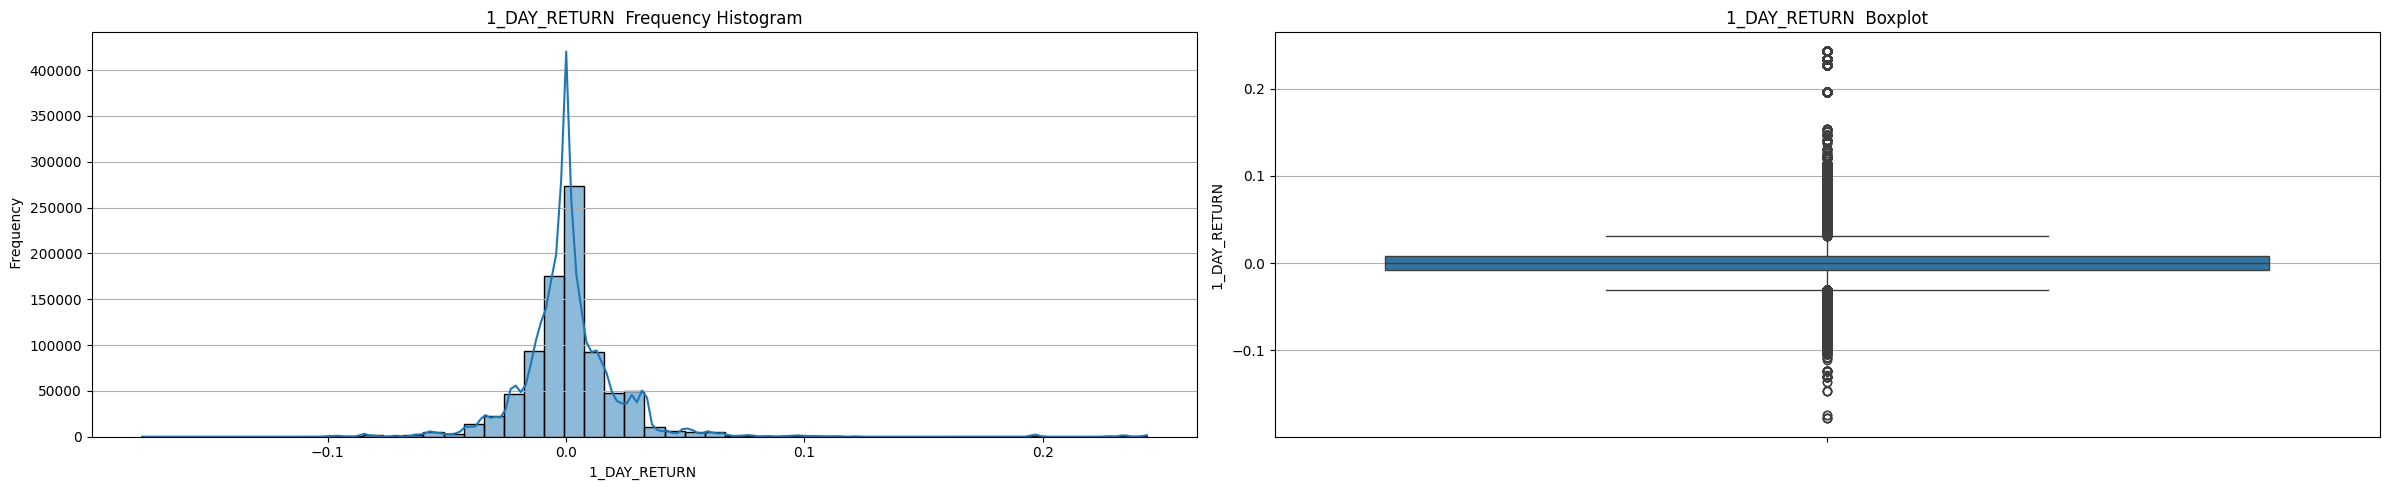

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>After Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
The Information of 1_DAY_RETURN :

count    1.395450e+06
mean     9.103542e-04
std      1.814714e-02
min     -1.778512e-01
25%     -1.564129e-03
50%      0.000000e+00
75%      1.134687e-03
max      2.436389e-01
Name: 1_DAY_RETURN, dtype: float64
Missing Value Count: 0


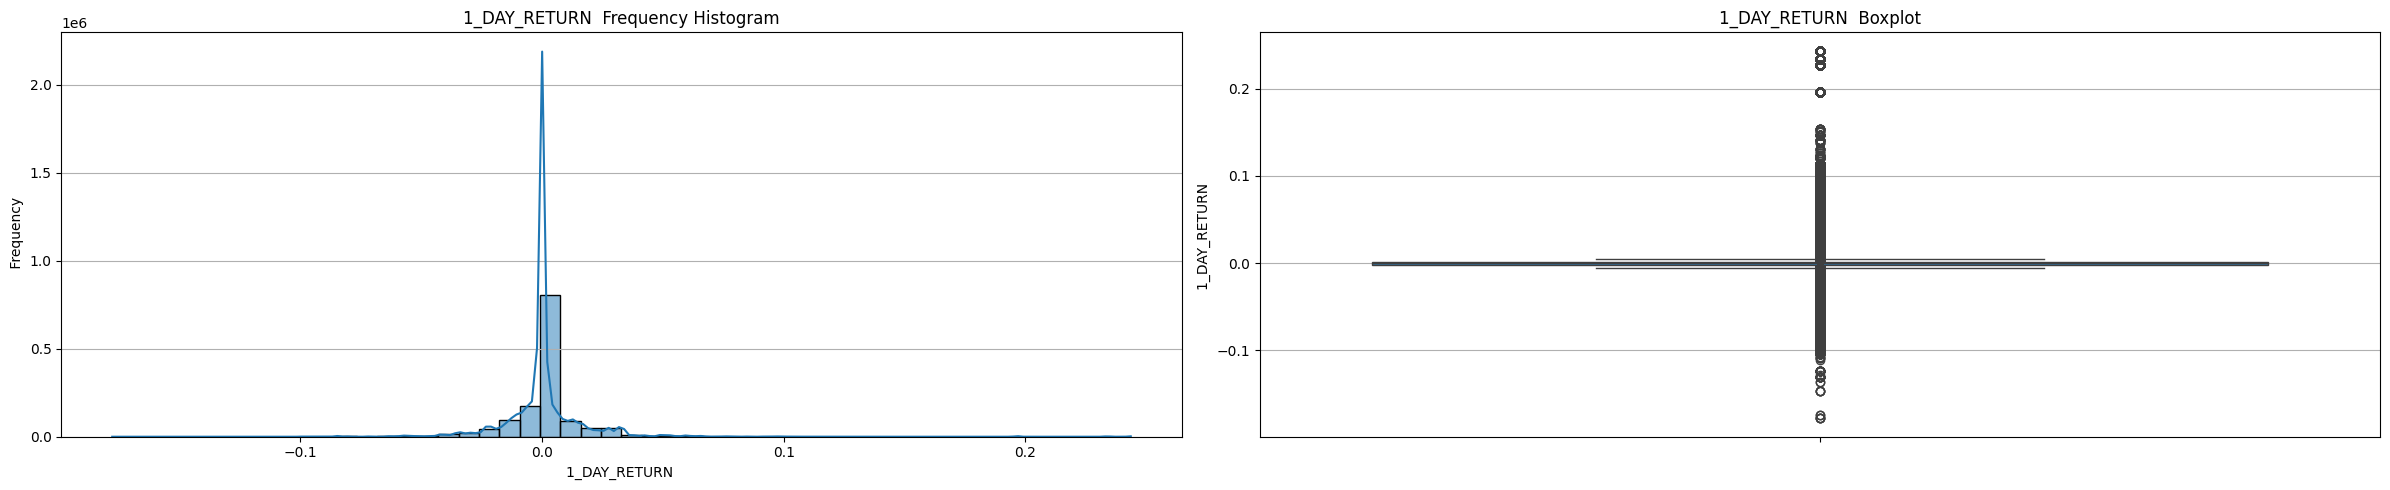

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [21]:
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Before Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
analyze_freq_and_box_numeric("1_DAY_RETURN ",df["1_DAY_RETURN"],draw=True,bin_set=50)
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>After Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
analyze_freq_and_box_numeric("1_DAY_RETURN ",data["1_DAY_RETURN"],draw=True,bin_set=50)
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

#### 3.4 根据属性的相关关系填补缺失值 
我们采用相关系数来判断两个属性间的相似度，并根据属性间的相似度，来寻找可替代的同类型属性，若相似度较低，则用该属性的均值填充

In [22]:
data = df.select_dtypes(include=['int64','float64']).copy(deep=True)

展示填补前的数据信息

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395450 entries, 0 to 1395449
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LAST_PRICE         862231 non-null  float64
 1   1_DAY_RETURN       862231 non-null  float64
 2   2_DAY_RETURN       862231 non-null  float64
 3   3_DAY_RETURN       862231 non-null  float64
 4   7_DAY_RETURN       862231 non-null  float64
 5   PX_VOLUME          862231 non-null  float64
 6   VOLATILITY_10D     862130 non-null  float64
 7   VOLATILITY_30D     862184 non-null  float64
 8   LSTM_POLARITY      661102 non-null  float64
 9   TEXTBLOB_POLARITY  367665 non-null  float64
dtypes: float64(10)
memory usage: 106.5 MB


In [24]:
data.head(10)

,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,1.000,0.0,NaN
2,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1.0,0.0
3,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,1.0,0.0
4,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1.0,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,-1.000,0.8,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.002621,-0.012201,-0.012201,-0.024853,8.485838e+06,12.229,12.982,1.000,0.0,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


对于其中所有属性数值都为NaN的数据对象，我们先将这些对象剔除这些对象

In [25]:
data.dropna(how='all', inplace=True)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 862231 entries, 1 to 1395449
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LAST_PRICE         862231 non-null  float64
 1   1_DAY_RETURN       862231 non-null  float64
 2   2_DAY_RETURN       862231 non-null  float64
 3   3_DAY_RETURN       862231 non-null  float64
 4   7_DAY_RETURN       862231 non-null  float64
 5   PX_VOLUME          862231 non-null  float64
 6   VOLATILITY_10D     862130 non-null  float64
 7   VOLATILITY_30D     862184 non-null  float64
 8   LSTM_POLARITY      661102 non-null  float64
 9   TEXTBLOB_POLARITY  367665 non-null  float64
dtypes: float64(10)
memory usage: 72.4 MB


In [27]:
data.head(10)

,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
1,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,1.344700e+01,16.992,1.000,0.000000,NaN
2,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,-1.000000,0.0
3,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,1.000000,0.0
4,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,-1.000000,0.0
6,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,1.344700e+01,16.992,-1.000,0.800000,NaN
8,0.002621,-0.012201,-0.012201,-0.024853,8.485838e+06,1.222900e+01,12.982,1.000,0.000000,NaN
10,0.005064,0.014273,0.014273,-0.007290,1.979048e+07,1.512100e+01,16.219,1.000,0.000000,NaN
11,55.220000,0.012314,0.016298,0.016298,5.831221e-02,1.430798e+07,23.916,17.298,1.000000,0.2
13,0.010682,0.021363,0.021363,-0.057807,9.469076e+06,3.302900e+01,22.932,1.000,-0.166667,NaN
15,0.010682,0.021363,0.021363,-0.057807,9.469076e+06,3.302900e+01,22.932,-1.000,0.000000,NaN


对于剔除全为NaN的数据行后的数据，我们寻找其中还存在NaN的属性。发现只有VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY这四个属性还存在NaN，下面我们对这几个属性进行缺失值填补

In [28]:
for i in data.columns:
    print("{}:{}".format(i,pd.isnull(data[i]).sum()))

LAST_PRICE:0
1_DAY_RETURN:0
2_DAY_RETURN:0
3_DAY_RETURN:0
7_DAY_RETURN:0
PX_VOLUME:0
VOLATILITY_10D:101
VOLATILITY_30D:47
LSTM_POLARITY:201129
TEXTBLOB_POLARITY:494566


下面以热力图的形式展示数据属性间的相关系数

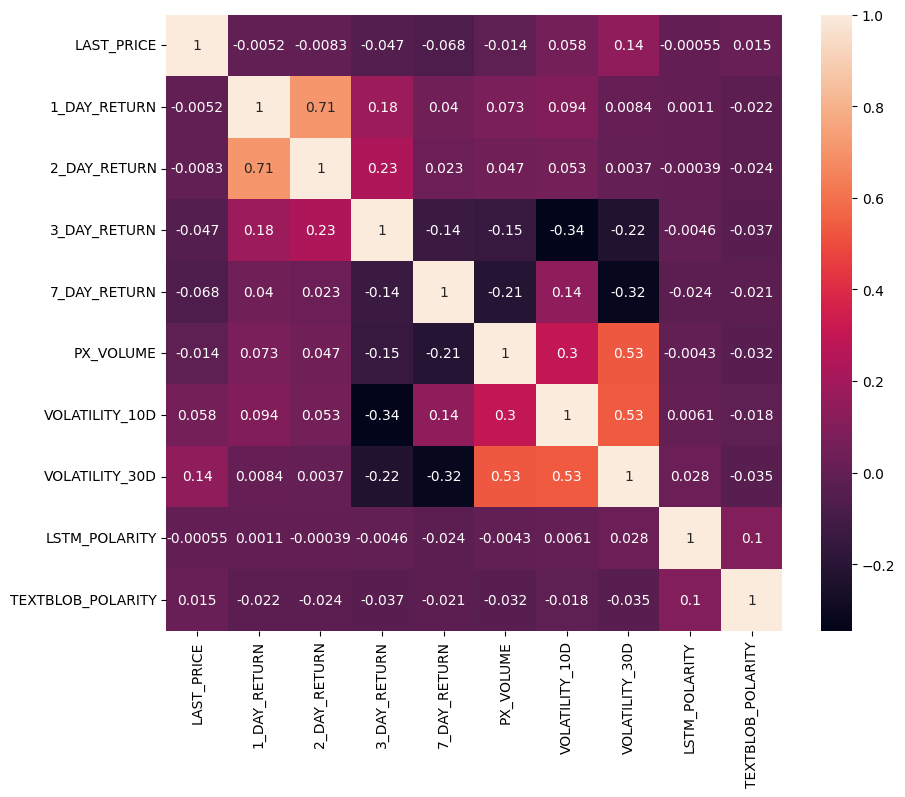

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), square=True, annot=True)
plt.show()

可以看到PX_VOLUME与VOLATILITY_10D,VOLATILITY_30D相关系数较高,分别为0.3和0.53。</br>
VOLATILITY_10D与VOLATILITY_30D相关系数较高为0.53</br>
所以我们尝试用这三个属性互相填补缺失值，对于LSTM_POLARITY和TEXTBLOB_POLARITY这两个属性，由于相关关系并不明显，所以用本身的均值填补

In [30]:
data["VOLATILITY_10D"] = data["VOLATILITY_10D"].fillna(data["PX_VOLUME"]*0.3 + data["VOLATILITY_30D"]*0.53)
data["VOLATILITY_30D"] = data["VOLATILITY_30D"].fillna(data["PX_VOLUME"]*0.3 + data["VOLATILITY_10D"]*0.53)
for i in data.columns:
    data[i] = data[i].fillna(data[i].mean())

填补后的数据集部分信息如下：

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 862231 entries, 1 to 1395449
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LAST_PRICE         862231 non-null  float64
 1   1_DAY_RETURN       862231 non-null  float64
 2   2_DAY_RETURN       862231 non-null  float64
 3   3_DAY_RETURN       862231 non-null  float64
 4   7_DAY_RETURN       862231 non-null  float64
 5   PX_VOLUME          862231 non-null  float64
 6   VOLATILITY_10D     862231 non-null  float64
 7   VOLATILITY_30D     862231 non-null  float64
 8   LSTM_POLARITY      862231 non-null  float64
 9   TEXTBLOB_POLARITY  862231 non-null  float64
dtypes: float64(10)
memory usage: 72.4 MB


In [32]:
data.head(10)

,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
1,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,1.344700e+01,16.992,1.000,0.000000,0.076176
2,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,-1.000000,0.000000
3,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,1.000000,0.000000
4,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,-1.000000,0.000000
6,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,1.344700e+01,16.992,-1.000,0.800000,0.076176
8,0.002621,-0.012201,-0.012201,-0.024853,8.485838e+06,1.222900e+01,12.982,1.000,0.000000,0.076176
10,0.005064,0.014273,0.014273,-0.007290,1.979048e+07,1.512100e+01,16.219,1.000,0.000000,0.076176
11,55.220000,0.012314,0.016298,0.016298,5.831221e-02,1.430798e+07,23.916,17.298,1.000000,0.200000
13,0.010682,0.021363,0.021363,-0.057807,9.469076e+06,3.302900e+01,22.932,1.000,-0.166667,0.076176
15,0.010682,0.021363,0.021363,-0.057807,9.469076e+06,3.302900e+01,22.932,-1.000,0.000000,0.076176


##### 比较处理前后数据集差异
下面以VOLATILITY_10D这一属性为例，对比数据集在剔除含缺失值数据对象后的差异

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Before Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
The Information of VOLATILITY_10D:

count    862130.000000
mean         18.293836
std          16.277630
min          -1.000000
25%           8.792000
50%          17.897000
75%          23.916000
max         124.137000
Name: VOLATILITY_10D, dtype: float64
Missing Value Count: 533320


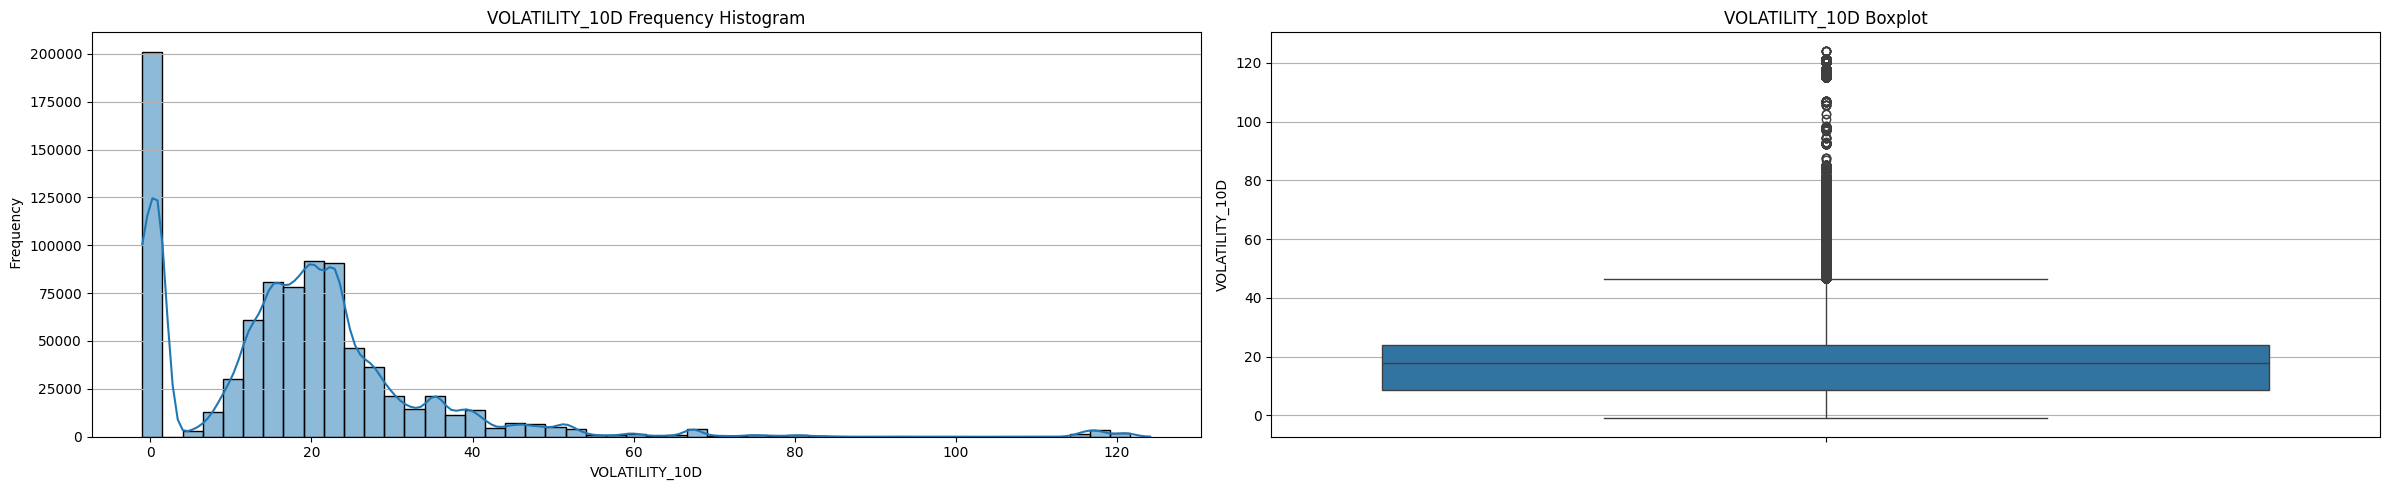

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>After Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
The Information of VOLATILITY_10D:

count    862231.000000
mean         18.294798
std          16.276925
min          -1.000000
25%           8.801000
50%          17.900000
75%          23.916000
max         124.137000
Name: VOLATILITY_10D, dtype: float64
Missing Value Count: 0


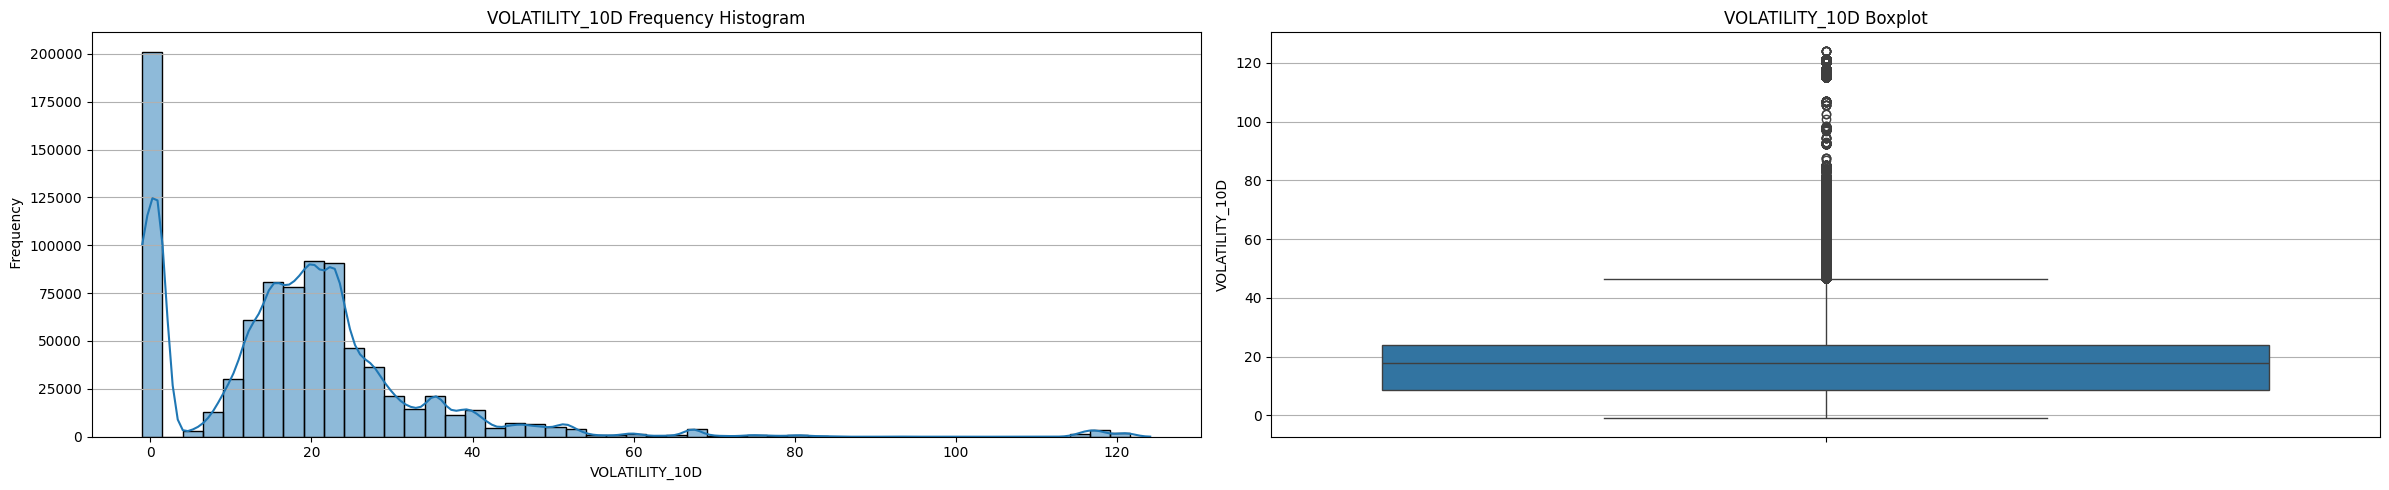

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [33]:
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Before Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
analyze_freq_and_box_numeric("VOLATILITY_10D",df["VOLATILITY_10D"],draw=True,bin_set=50)
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>After Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
analyze_freq_and_box_numeric("VOLATILITY_10D",data["VOLATILITY_10D"],draw=True,bin_set=50)
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

#### 3.5 通过数据对象之间的相似性来填补缺失值
我们将数值属性向量化，然后使用K临近算法——KNN来计算数据对象间的距离，以此来判断数据对象间的相似性，再根据寻找的k个相似的数据对象的相关信息来填补当前对象的缺失值

In [34]:
numeric_df = df.select_dtypes(include=['int64','float64']).copy(deep=True)

In [35]:
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395450 entries, 0 to 1395449
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LAST_PRICE         862231 non-null  float64
 1   1_DAY_RETURN       862231 non-null  float64
 2   2_DAY_RETURN       862231 non-null  float64
 3   3_DAY_RETURN       862231 non-null  float64
 4   7_DAY_RETURN       862231 non-null  float64
 5   PX_VOLUME          862231 non-null  float64
 6   VOLATILITY_10D     862130 non-null  float64
 7   VOLATILITY_30D     862184 non-null  float64
 8   LSTM_POLARITY      661102 non-null  float64
 9   TEXTBLOB_POLARITY  367665 non-null  float64
dtypes: float64(10)
memory usage: 106.5 MB


In [36]:
numeric_df.head(10)

,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,1.000,0.0,NaN
2,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1.0,0.0
3,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,1.0,0.0
4,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1.0,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,-1.000,0.8,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.002621,-0.012201,-0.012201,-0.024853,8.485838e+06,12.229,12.982,1.000,0.0,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


对于其中所有属性数值都为NaN的数据对象，我们先将这些对象剔除这些对象

In [37]:
numeric_df.dropna(how='all', inplace=True)

In [38]:
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 862231 entries, 1 to 1395449
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LAST_PRICE         862231 non-null  float64
 1   1_DAY_RETURN       862231 non-null  float64
 2   2_DAY_RETURN       862231 non-null  float64
 3   3_DAY_RETURN       862231 non-null  float64
 4   7_DAY_RETURN       862231 non-null  float64
 5   PX_VOLUME          862231 non-null  float64
 6   VOLATILITY_10D     862130 non-null  float64
 7   VOLATILITY_30D     862184 non-null  float64
 8   LSTM_POLARITY      661102 non-null  float64
 9   TEXTBLOB_POLARITY  367665 non-null  float64
dtypes: float64(10)
memory usage: 72.4 MB


In [39]:
numeric_df.head(10)

,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
1,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,1.344700e+01,16.992,1.000,0.000000,NaN
2,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,-1.000000,0.0
3,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,1.000000,0.0
4,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,-1.000000,0.0
6,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,1.344700e+01,16.992,-1.000,0.800000,NaN
8,0.002621,-0.012201,-0.012201,-0.024853,8.485838e+06,1.222900e+01,12.982,1.000,0.000000,NaN
10,0.005064,0.014273,0.014273,-0.007290,1.979048e+07,1.512100e+01,16.219,1.000,0.000000,NaN
11,55.220000,0.012314,0.016298,0.016298,5.831221e-02,1.430798e+07,23.916,17.298,1.000000,0.2
13,0.010682,0.021363,0.021363,-0.057807,9.469076e+06,3.302900e+01,22.932,1.000,-0.166667,NaN
15,0.010682,0.021363,0.021363,-0.057807,9.469076e+06,3.302900e+01,22.932,-1.000,0.000000,NaN


对于剔除全为NaN的数据行后的数据，我们寻找其中还存在NaN的属性。发现只有VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY这四个属性还存在NaN，下面我们对这几个属性进行缺失值填补

In [40]:
for i in numeric_df.columns:
    print("{}:{}".format(i,pd.isnull(numeric_df[i]).sum()))

LAST_PRICE:0
1_DAY_RETURN:0
2_DAY_RETURN:0
3_DAY_RETURN:0
7_DAY_RETURN:0
PX_VOLUME:0
VOLATILITY_10D:101
VOLATILITY_30D:47
LSTM_POLARITY:201129
TEXTBLOB_POLARITY:494566


调用KNN的包来对数据进行填补，我们选择k=2作为参数</br>
由于knn算法的时间复杂度较大，这里我们仅选择**前50000条数据**进行填补

In [41]:
data = numeric_df.copy()[0:50000]

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1 to 84960
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LAST_PRICE         50000 non-null  float64
 1   1_DAY_RETURN       50000 non-null  float64
 2   2_DAY_RETURN       50000 non-null  float64
 3   3_DAY_RETURN       50000 non-null  float64
 4   7_DAY_RETURN       50000 non-null  float64
 5   PX_VOLUME          50000 non-null  float64
 6   VOLATILITY_10D     49996 non-null  float64
 7   VOLATILITY_30D     49990 non-null  float64
 8   LSTM_POLARITY      30854 non-null  float64
 9   TEXTBLOB_POLARITY  15041 non-null  float64
dtypes: float64(10)
memory usage: 4.2 MB


In [43]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=2)

df_imputed = knn_imputer.fit_transform(data)

data = pd.DataFrame(df_imputed, columns=data.columns)

展示填补后的数据信息

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LAST_PRICE         50000 non-null  float64
 1   1_DAY_RETURN       50000 non-null  float64
 2   2_DAY_RETURN       50000 non-null  float64
 3   3_DAY_RETURN       50000 non-null  float64
 4   7_DAY_RETURN       50000 non-null  float64
 5   PX_VOLUME          50000 non-null  float64
 6   VOLATILITY_10D     50000 non-null  float64
 7   VOLATILITY_30D     50000 non-null  float64
 8   LSTM_POLARITY      50000 non-null  float64
 9   TEXTBLOB_POLARITY  50000 non-null  float64
dtypes: float64(10)
memory usage: 3.8 MB


In [45]:
data.head(10)

,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,1.344700e+01,16.992,1.000,0.000000,0.0
1,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,-1.000000,0.0
2,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,1.000000,0.0
3,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9.100057e+06,18.769,16.099,-1.000000,0.0
4,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,1.344700e+01,16.992,-1.000,0.800000,0.0
5,0.002621,-0.012201,-0.012201,-0.024853,8.485838e+06,1.222900e+01,12.982,1.000,0.000000,0.0
6,0.005064,0.014273,0.014273,-0.007290,1.979048e+07,1.512100e+01,16.219,1.000,0.000000,0.0
7,55.220000,0.012314,0.016298,0.016298,5.831221e-02,1.430798e+07,23.916,17.298,1.000000,0.2
8,0.010682,0.021363,0.021363,-0.057807,9.469076e+06,3.302900e+01,22.932,1.000,-0.166667,0.0
9,0.010682,0.021363,0.021363,-0.057807,9.469076e+06,3.302900e+01,22.932,-1.000,0.000000,0.0


##### 比较处理前后数据集差异
下面以LSTM_POLARITY这一属性为例，对比数据集在剔除含缺失值数据对象后的差异

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Before Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
The Information of LSTM_POLARITY:

count    24372.000000
mean         0.101871
std          0.630868
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.500000
max          1.000000
Name: LSTM_POLARITY, dtype: float64
Missing Value Count: 25628


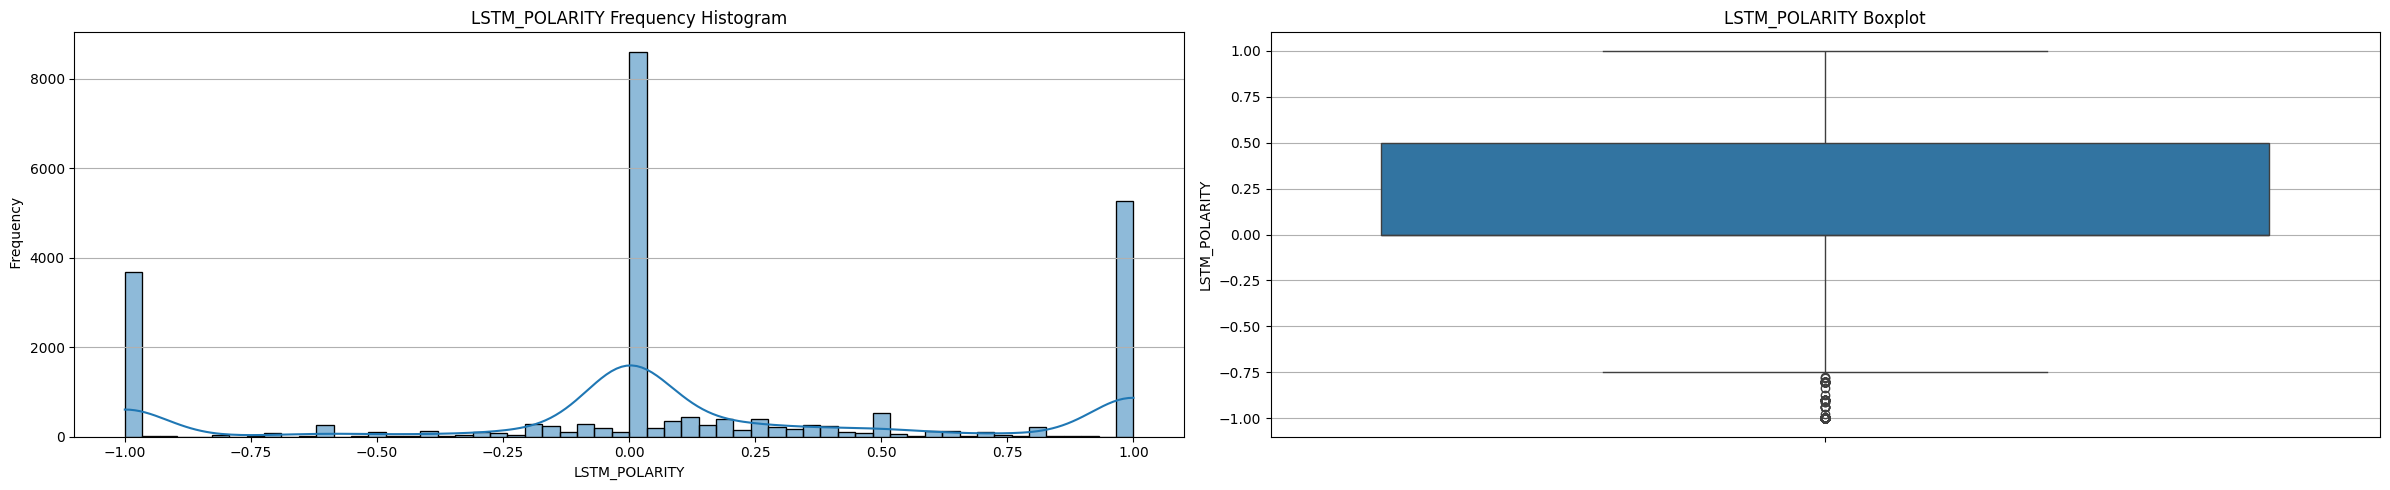

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>After Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
The Information of LSTM_POLARITY:

count    50000.000000
mean        -0.312407
std          0.782027
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          0.154643
max          1.000000
Name: LSTM_POLARITY, dtype: float64
Missing Value Count: 0


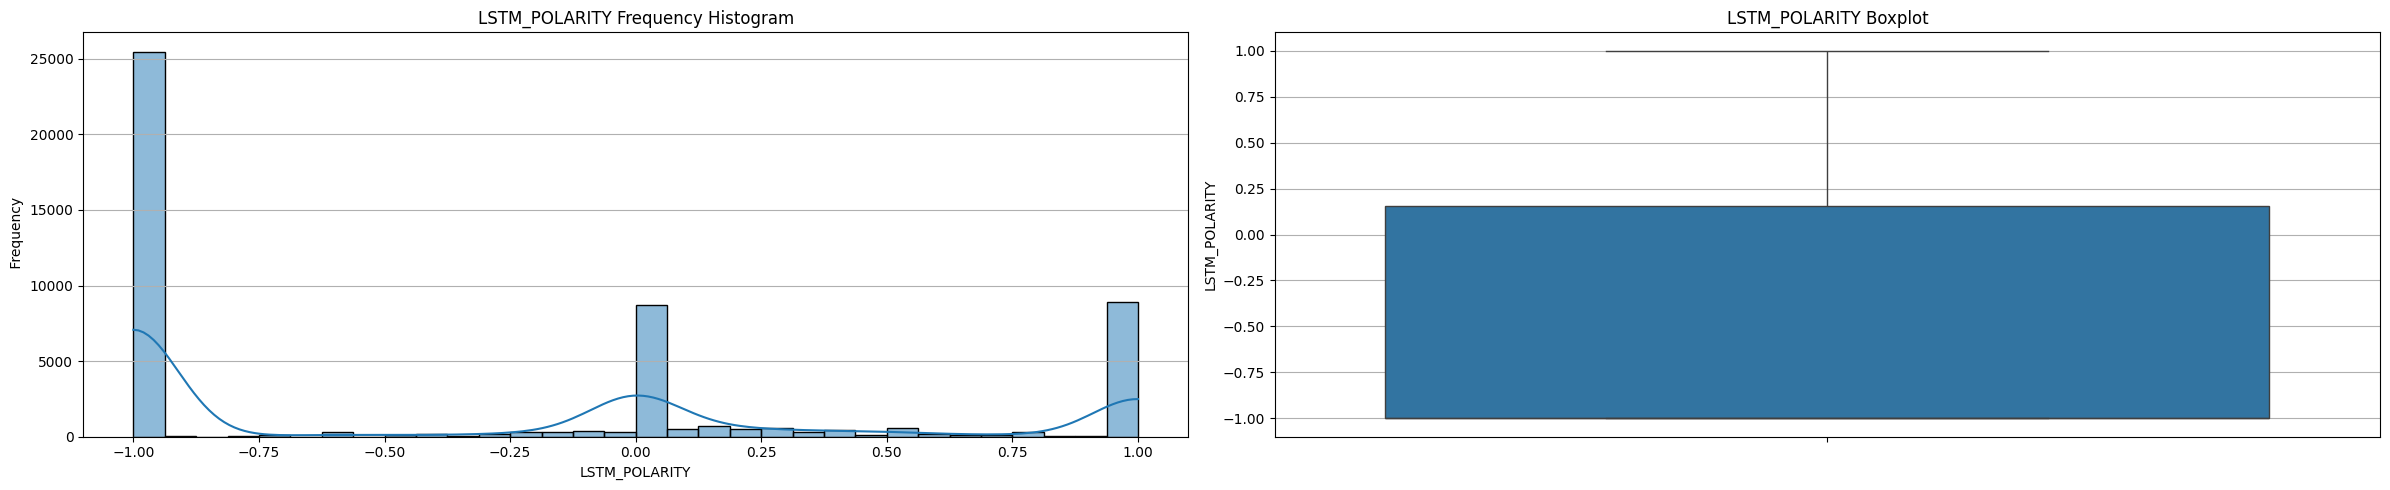

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [46]:
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Before Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
analyze_freq_and_box_numeric("LSTM_POLARITY",df["LSTM_POLARITY"][0:50000])
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>After Processing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
analyze_freq_and_box_numeric("LSTM_POLARITY",data["LSTM_POLARITY"])
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

### 总结
至此，我们对Tweet Sentiment's Impact on Stock Returns数据集的预处理和探索性分析全部完成